In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyro-ppl

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import torch
import pyro
from pyro import distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler,MinMaxScaler

%matplotlib inline

Ссылка на используемый датасет - https://www.kaggle.com/datasets/mohamedhamad21/spotify-tracks-dataset

In [ ]:
df_name = "/content/drive/MyDrive/MLNNM/dataset_m.csv"
df = pd.read_csv(df_name)
df

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,NaN,...,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            108300 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

Ниже представлено описание столбцов датасета

|        **Признак**        |                  **Значение**                  |
|:-------------------------:|:----------------------------------------------:|
|track_id|Уникальный идентификатор трека|
|artists|Исполнители трека|
|album_name|Название альбома, в который входит трек|
|track_name|Название трека|
|popularity|Популярность трека|
|duration_ms|Длительность трека в миллисекундах|
|explicit|Наличие в треке контента с неприемлемыми для детей словами или темами|
|danceability|Танцевальность трека|
|energy| Энергичность трека|
|key|Музыкальный ключ (тональность) трека|
|loudness|Средняя громкость трека в децибелах|
|mode| Режим тональности трека (0 = минор, 1 = мажор)|
|speechiness|Речь в треке|
|acousticness|Акустичность трека|
|instrumentalness|Инструментальность трека|
|liveness|Живость трека,вероятность того, что трек был записан на живом концерте|
|valence|Позитивность трека|
|tempo|Темп трека, измеряемый в ударах в минуту (BPM)|
|time_signature|Размер такта трека|
|track_genre| Жанр трека|



В датасете наблюдаются признаки:

* **количественные**: popularity, duration_ms, danceability, energy, key, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo.

* **категориальные**: track_id, artists, album_name, track_name, explicit, mode, time_signature, track_genre.

In [ ]:
df.drop(columns={'Unnamed: 0'}, inplace=True)

С целью упрощения анализа, оставим в датасете только некоторые столбцы.

In [ ]:
df = df[
    ["popularity", "duration_ms",
     "explicit", "danceability", "energy", "loudness", "speechiness",
     "acousticness", "instrumentalness", "liveness", "valence", "tempo", "track_genre"]
]

Посмотрим, содержат ли столбцы пропущенные значения.

In [ ]:
df.isnull().sum()

popularity             0
duration_ms            0
explicit               0
danceability           0
energy              5700
loudness               0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
track_genre            0
dtype: int64

Пропущенные значения будем заполнять в дальнейшем с применением байесовской модели.

Посмотрим на статистику данных.

In [ ]:
df.describe()

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,114000.000000,1.140000e+05,114000.000000,108300.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,33.238535,2.280292e+05,0.566800,0.641771,-8.258960,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837
std,22.305078,1.072977e+05,0.173542,0.251419,5.029337,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197
min,0.000000,0.000000e+00,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.456000,0.472000,-10.013000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750
50%,35.000000,2.129060e+05,0.580000,0.685000,-7.004000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000
75%,50.000000,2.615060e+05,0.695000,0.854000,-5.003000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000
max,100.000000,5.237295e+06,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000


In [ ]:
df

,popularity,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre
0,73,230666,False,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,acoustic
1,55,149610,False,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,acoustic
2,57,210826,False,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,acoustic
3,71,201933,False,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,acoustic
4,82,198853,False,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,False,0.172,0.2350,-16.393,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,world-music
113996,22,385000,False,0.174,0.1170,-18.318,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,world-music
113997,22,271466,False,0.629,0.3290,-10.895,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,world-music
113998,41,283893,False,0.587,NaN,-10.889,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,world-music


In [ ]:
import pandas as pd

# Замена True на 1 и False на 0
df['explicit'] = df['explicit'].astype(int)

<ipython-input-11-aa6fcb8a5f7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['explicit'] = df['explicit'].astype(int)


Трансформируем

In [ ]:
num_features = ["duration_ms", "explicit", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]
cat_features = ["track_genre"]

column_transformer = ColumnTransformer([
    ("cat_transformer", OrdinalEncoder(dtype='int'), cat_features),
    ("num_transformer", MinMaxScaler(), num_features)
], remainder='passthrough', verbose_feature_names_out=False)

In [ ]:
column_transformer.set_output(transform="pandas")
df = column_transformer.fit_transform(df)
df

,track_genre,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
0,0,0.044043,0.0,0.686294,0.4610,0.791392,0.148187,0.032329,0.000001,0.3580,0.718593,0.361245,73
1,0,0.028566,0.0,0.426396,0.1660,0.597377,0.079067,0.927711,0.000006,0.1010,0.268342,0.318397,55
2,0,0.040255,0.0,0.444670,0.3590,0.736123,0.057720,0.210843,0.000000,0.1170,0.120603,0.313643,57
3,0,0.038557,0.0,0.270051,0.0596,0.573701,0.037617,0.908635,0.000071,0.1320,0.143719,0.746758,71
4,0,0.037969,0.0,0.627411,0.4430,0.737103,0.054508,0.470884,0.000000,0.0829,0.167839,0.492863,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113,0.073511,0.0,0.174619,0.2350,0.612952,0.043731,0.642570,0.928000,0.0863,0.034070,0.517705,21
113996,113,0.073511,0.0,0.176650,0.1170,0.577345,0.041554,0.997992,0.976000,0.1050,0.035176,0.350242,22
113997,113,0.051833,0.0,0.638579,0.3290,0.714648,0.043523,0.870482,0.000000,0.0839,0.746734,0.543933,22
113998,113,0.054206,0.0,0.595939,NaN,0.714759,0.030777,0.382530,0.000000,0.2700,0.415075,0.558651,41


In [ ]:
df.describe()

,track_genre,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
count,114000.000000,114000.000000,114000.000000,114000.000000,108300.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56.500000,0.043539,0.085500,0.575432,0.641771,0.763406,0.087722,0.316175,0.156050,0.213553,0.476450,0.501898,33.238535
std,32.907844,0.020487,0.279626,0.176185,0.251419,0.093027,0.109567,0.333858,0.309555,0.190378,0.260564,0.123178,22.305078
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,0.033236,0.000000,0.462944,0.472000,0.730962,0.037202,0.016968,0.000000,0.098000,0.261307,0.407684,17.000000
50%,56.500000,0.040652,0.000000,0.588832,0.685000,0.786619,0.050674,0.169679,0.000042,0.132000,0.466332,0.501360,35.000000
75%,85.000000,0.049932,0.000000,0.705584,0.854000,0.823632,0.087565,0.600402,0.049000,0.273000,0.686432,0.575543,50.000000
max,113.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_predict = train_test_split(df, test_size=0.2, random_state=42)

Поставим __задачу регрессии__ следующим образом: предсказать популярность трека по его характеристикам, представленным в датасете. Одновременно с решением задачи регрессии следует заполнить пропуски в столбце "energy". Требуется визуализовать априорные распределения коэффициентов байесовской модели, распределение целевой переменной для произвольного объекта тестового датасета.

In [ ]:
def model(data: pd.DataFrame, y: pd.Series = None):
    b_danceability = pyro.sample("b_danceability", dist.Normal(0, 1))
    b_energy = pyro.sample("b_energy", dist.Normal(0, 1))
    b_duration_ms = pyro.sample("b_duration_ms", dist.Normal(0, 1))
    b_loudness = pyro.sample("b_loudness", dist.Normal(0, 1))
    b_speechiness = pyro.sample("b_speechiness", dist.Normal(0, 1))
    b_acousticness = pyro.sample("b_acousticness", dist.Normal(0, 1))
    b_instrumentalness = pyro.sample("b_instrumentalness", dist.Normal(0, 1))
    b_liveness = pyro.sample("b_liveness", dist.Normal(0, 1))
    b_valence = pyro.sample("b_valence", dist.Normal(0, 1))
    b_tempo = pyro.sample("b_tempo", dist.Normal(0, 1))

    # Логиты
    logits = b_danceability * torch.tensor(data["danceability"].values)
    logits += b_duration_ms * torch.tensor(data["duration_ms"].values)
    logits += b_loudness * torch.tensor(data["loudness"].values)
    logits += b_speechiness * torch.tensor(data["speechiness"].values)
    logits += b_acousticness * torch.tensor(data["acousticness"].values)
    logits += b_instrumentalness * torch.tensor(data["instrumentalness"].values)
    logits += b_liveness * torch.tensor(data["liveness"].values)
    logits += b_valence * torch.tensor(data["valence"].values)
    logits += b_tempo * torch.tensor(data["tempo"].values)

    # Заполнение пропусков в столбце energy
    mu_energy = pyro.sample("mu_energy", dist.Normal(0, 1))
    std_energy = pyro.sample("std_energy", dist.HalfNormal(1))

    impute_energy = pyro.sample(
        "impute_energy", dist.Normal(mu_energy, std_energy).mask(False)
    )

    energy = torch.tensor(data["energy"].values)
    energy = torch.where(torch.isnan(energy), impute_energy, energy)

    logits += b_energy * energy

    obs = None if y is None else torch.tensor(y.values, dtype=torch.float32)

    for i in pyro.plate("N", len(data.index)):
      pyro.sample("energy", dist.Normal(mu_energy, std_energy), obs = energy)

      return pyro.sample("popularity", dist.Normal(logits, 1), obs=obs)

Визуализируем графическую вероятностную модель, соответствующую совместному распределению данных и весов.

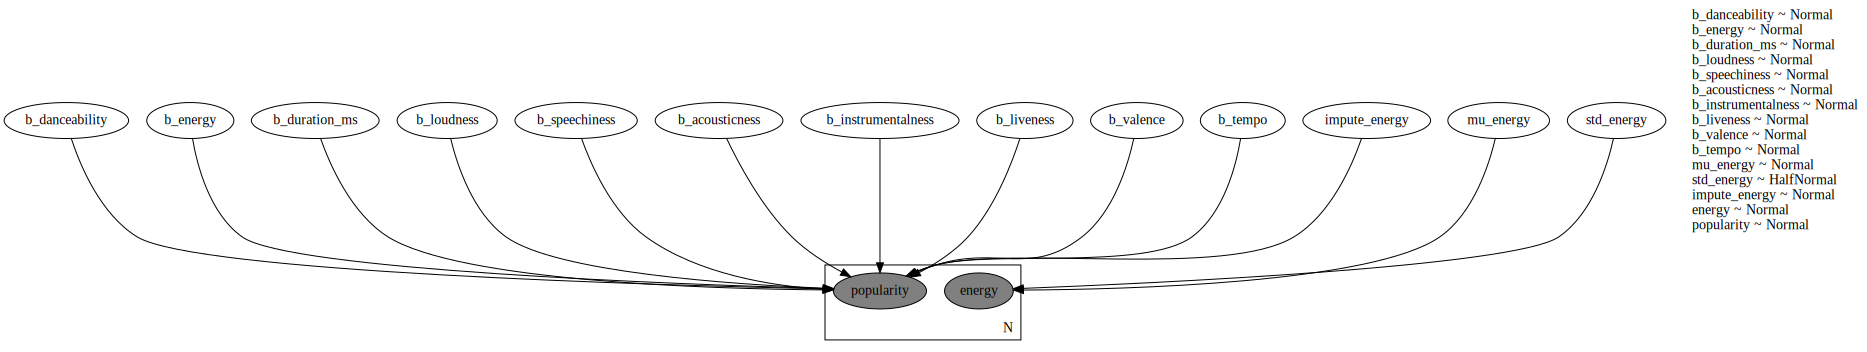

In [ ]:
pyro.render_model(model,
                  model_args=(df_train, df_train["popularity"]),
                  render_distributions=True,
                  render_params=True)

Выполним инференс модели с использованием марковских последовательностей Монте-Карло (MCMC).

Данная процедура выполняет нахождение апостериорного распределения весов модели, многократно сэмплируя из совместного распределения и приводя распределение сэмплов к апостериорному распределению весов.

Процедура сэмплирования может быть достаточно длительной.

In [ ]:
num_of_samples = 400

mcmc = MCMC(NUTS(model, jit_compile=True), num_samples=num_of_samples)
mcmc.run(df_train, df_train["popularity"])

mcmc.summary()

Warmup:   0%|          | 0/800 [00:00, ?it/s]<ipython-input-16-cd5aaaabd2ef>:14: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  logits = b_danceability * torch.tensor(data["danceability"].values)
<ipython-input-16-cd5aaaabd2ef>:15: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  logits += b_duration_ms * torch.tensor(data["duration_ms"].values)
<ipython-input-16-cd5aaaabd2ef>:16: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore th


                          mean       std    median      5.0%     95.0%     n_eff     r_hat
      b_acousticness      3.32      0.01      3.32      3.30      3.35    122.50      1.00
      b_danceability     11.51      0.02     11.51     11.47     11.54    144.84      1.00
       b_duration_ms      9.25      0.15      9.26      9.03      9.51    414.61      1.00
            b_energy     -6.29      0.02     -6.29     -6.33     -6.25     89.39      1.01
  b_instrumentalness     -4.23      0.01     -4.23     -4.24     -4.21    310.66      1.00
          b_liveness      2.72      0.02      2.72      2.69      2.75    286.10      1.00
          b_loudness     40.08      0.04     40.09     40.02     40.13    144.85      1.00
       b_speechiness    -11.10      0.03    -11.09    -11.14    -11.05    203.66      1.00
             b_tempo      8.46      0.03      8.46      8.41      8.50    575.40      1.00
           b_valence     -9.91      0.02     -9.91     -9.93     -9.88    214.54      1.0

In [ ]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(df_predict)
prior = Predictive(model, num_samples=num_of_samples)(df_predict)

In [ ]:
pyro_data = az.from_pyro(
    mcmc, prior=prior, posterior_predictive=posterior_predictive
)
pyro_data

/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

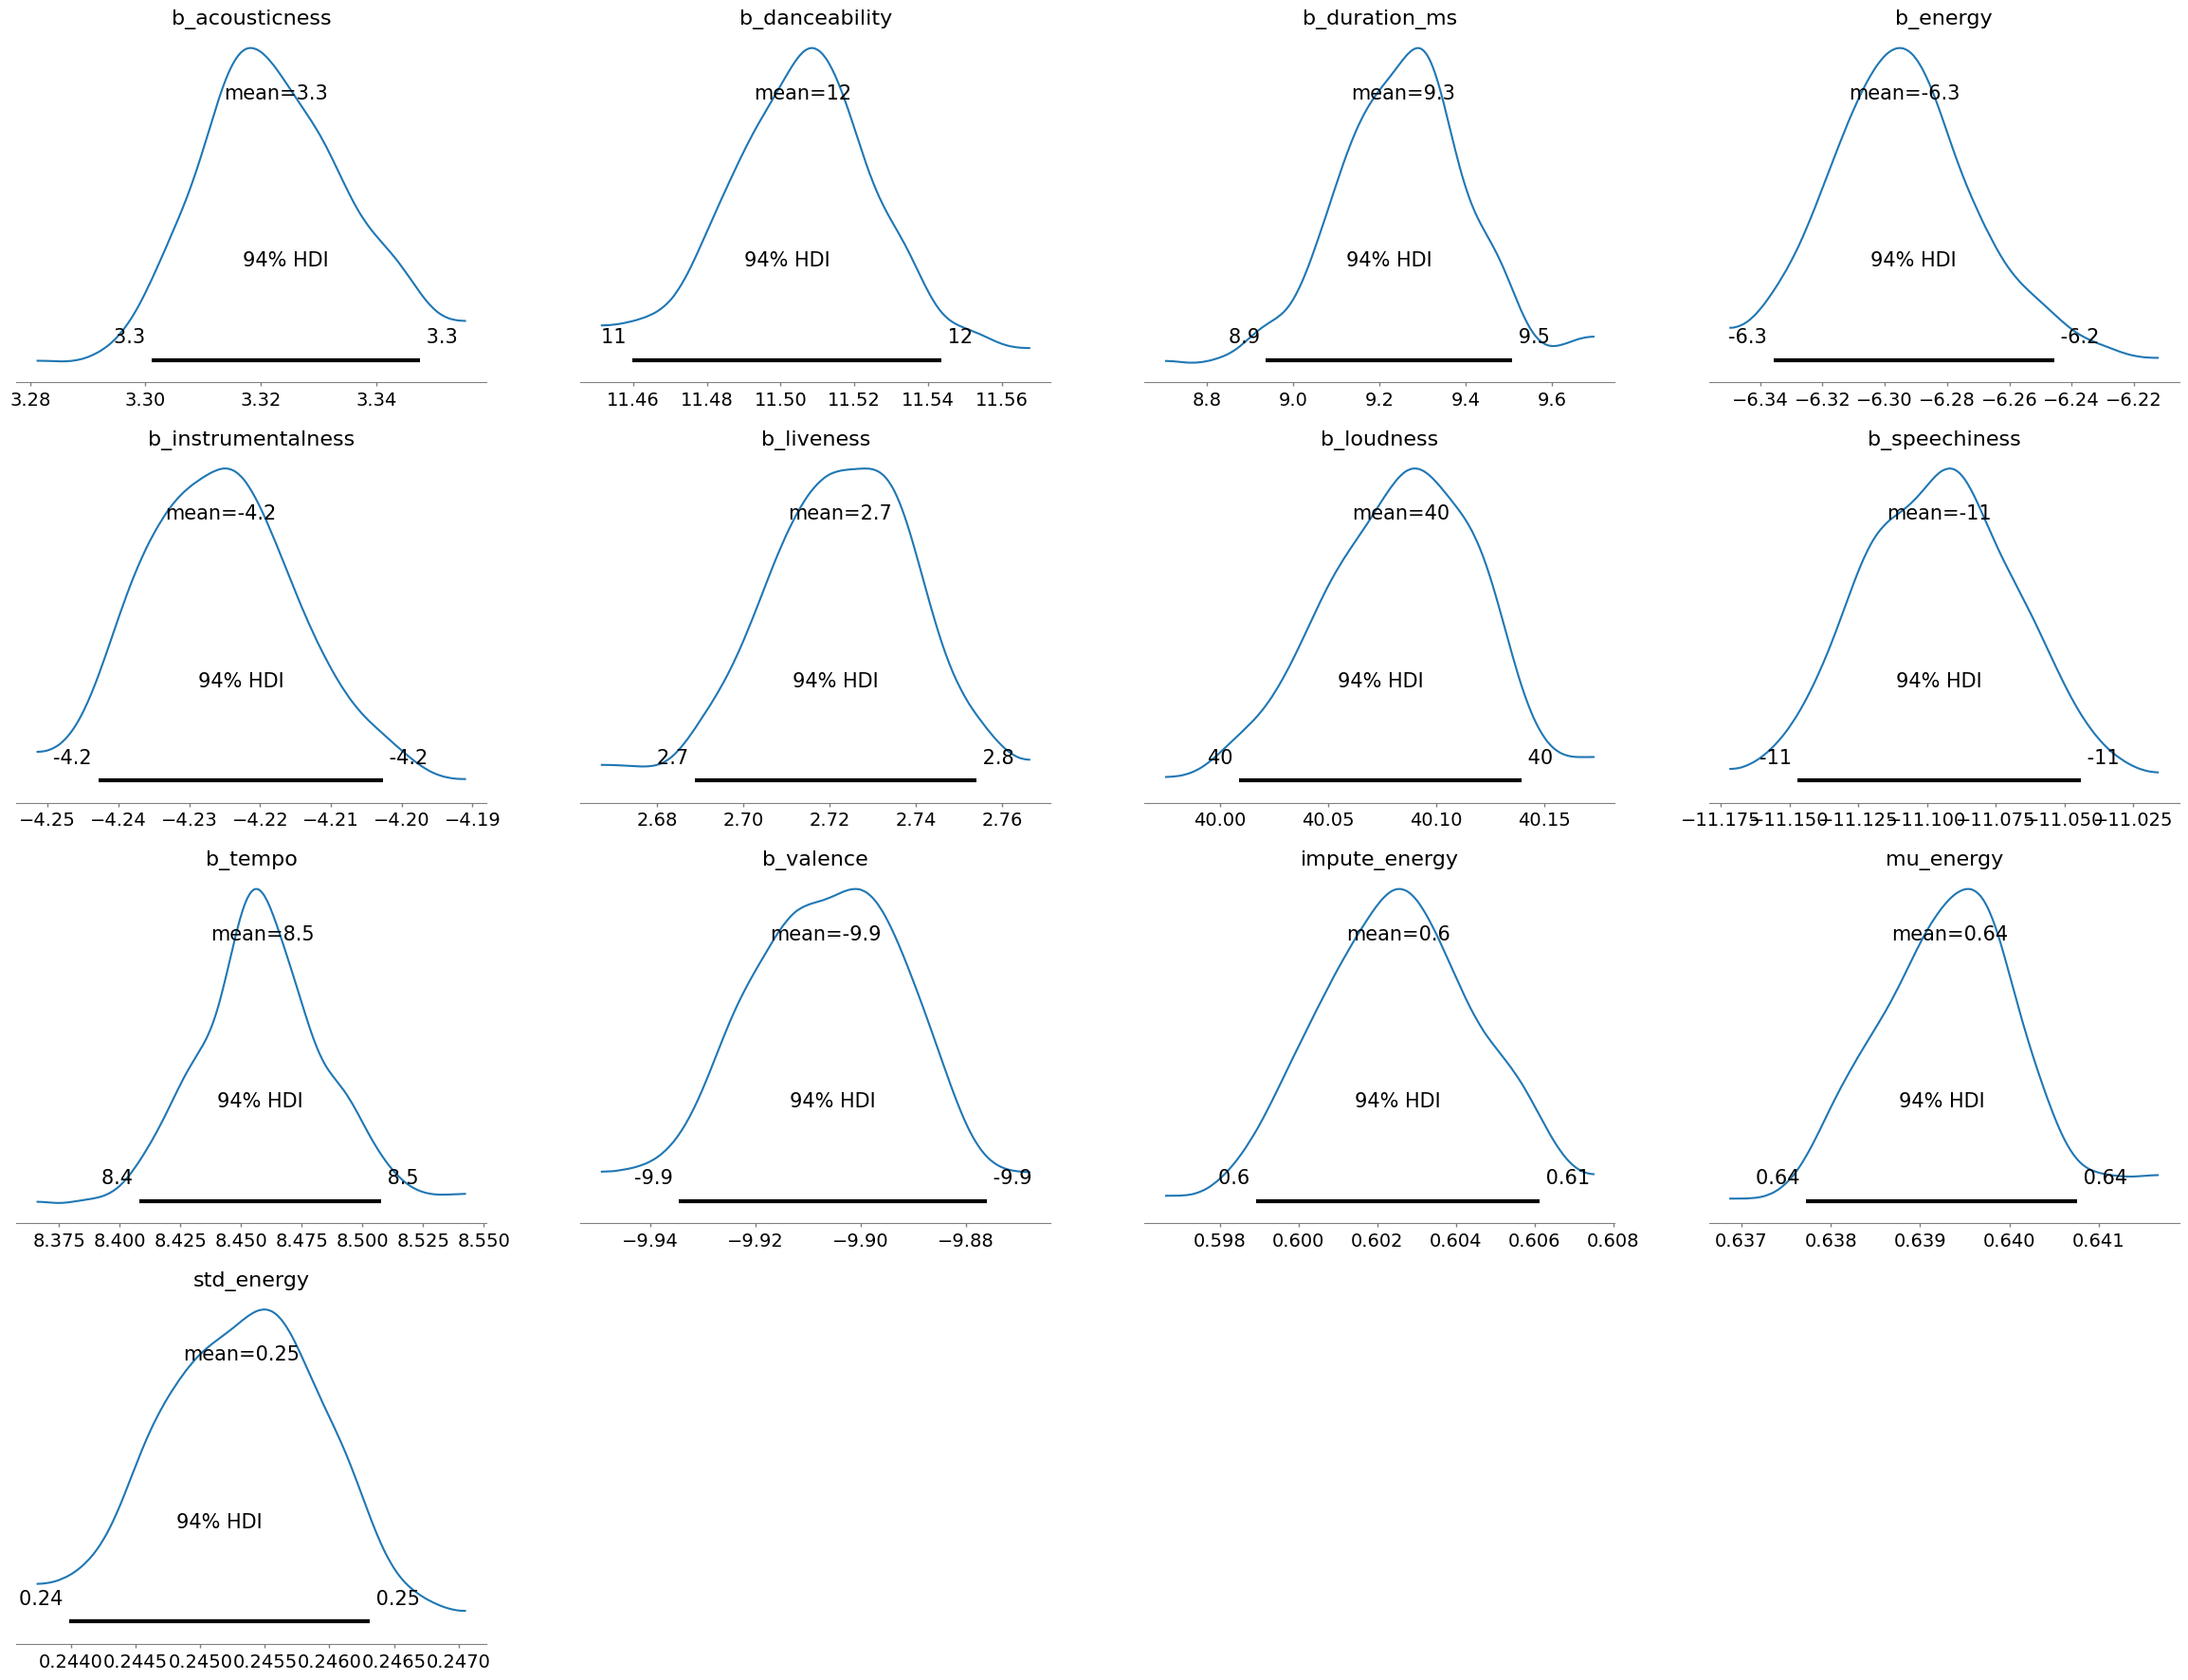

In [ ]:
az.plot_posterior(pyro_data);

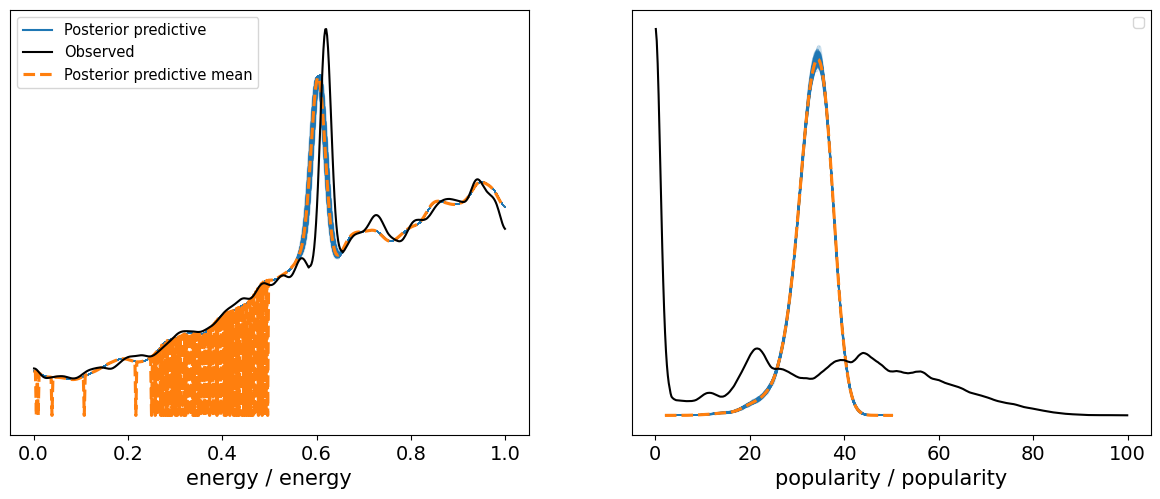

In [ ]:
az.plot_ppc(pyro_data);

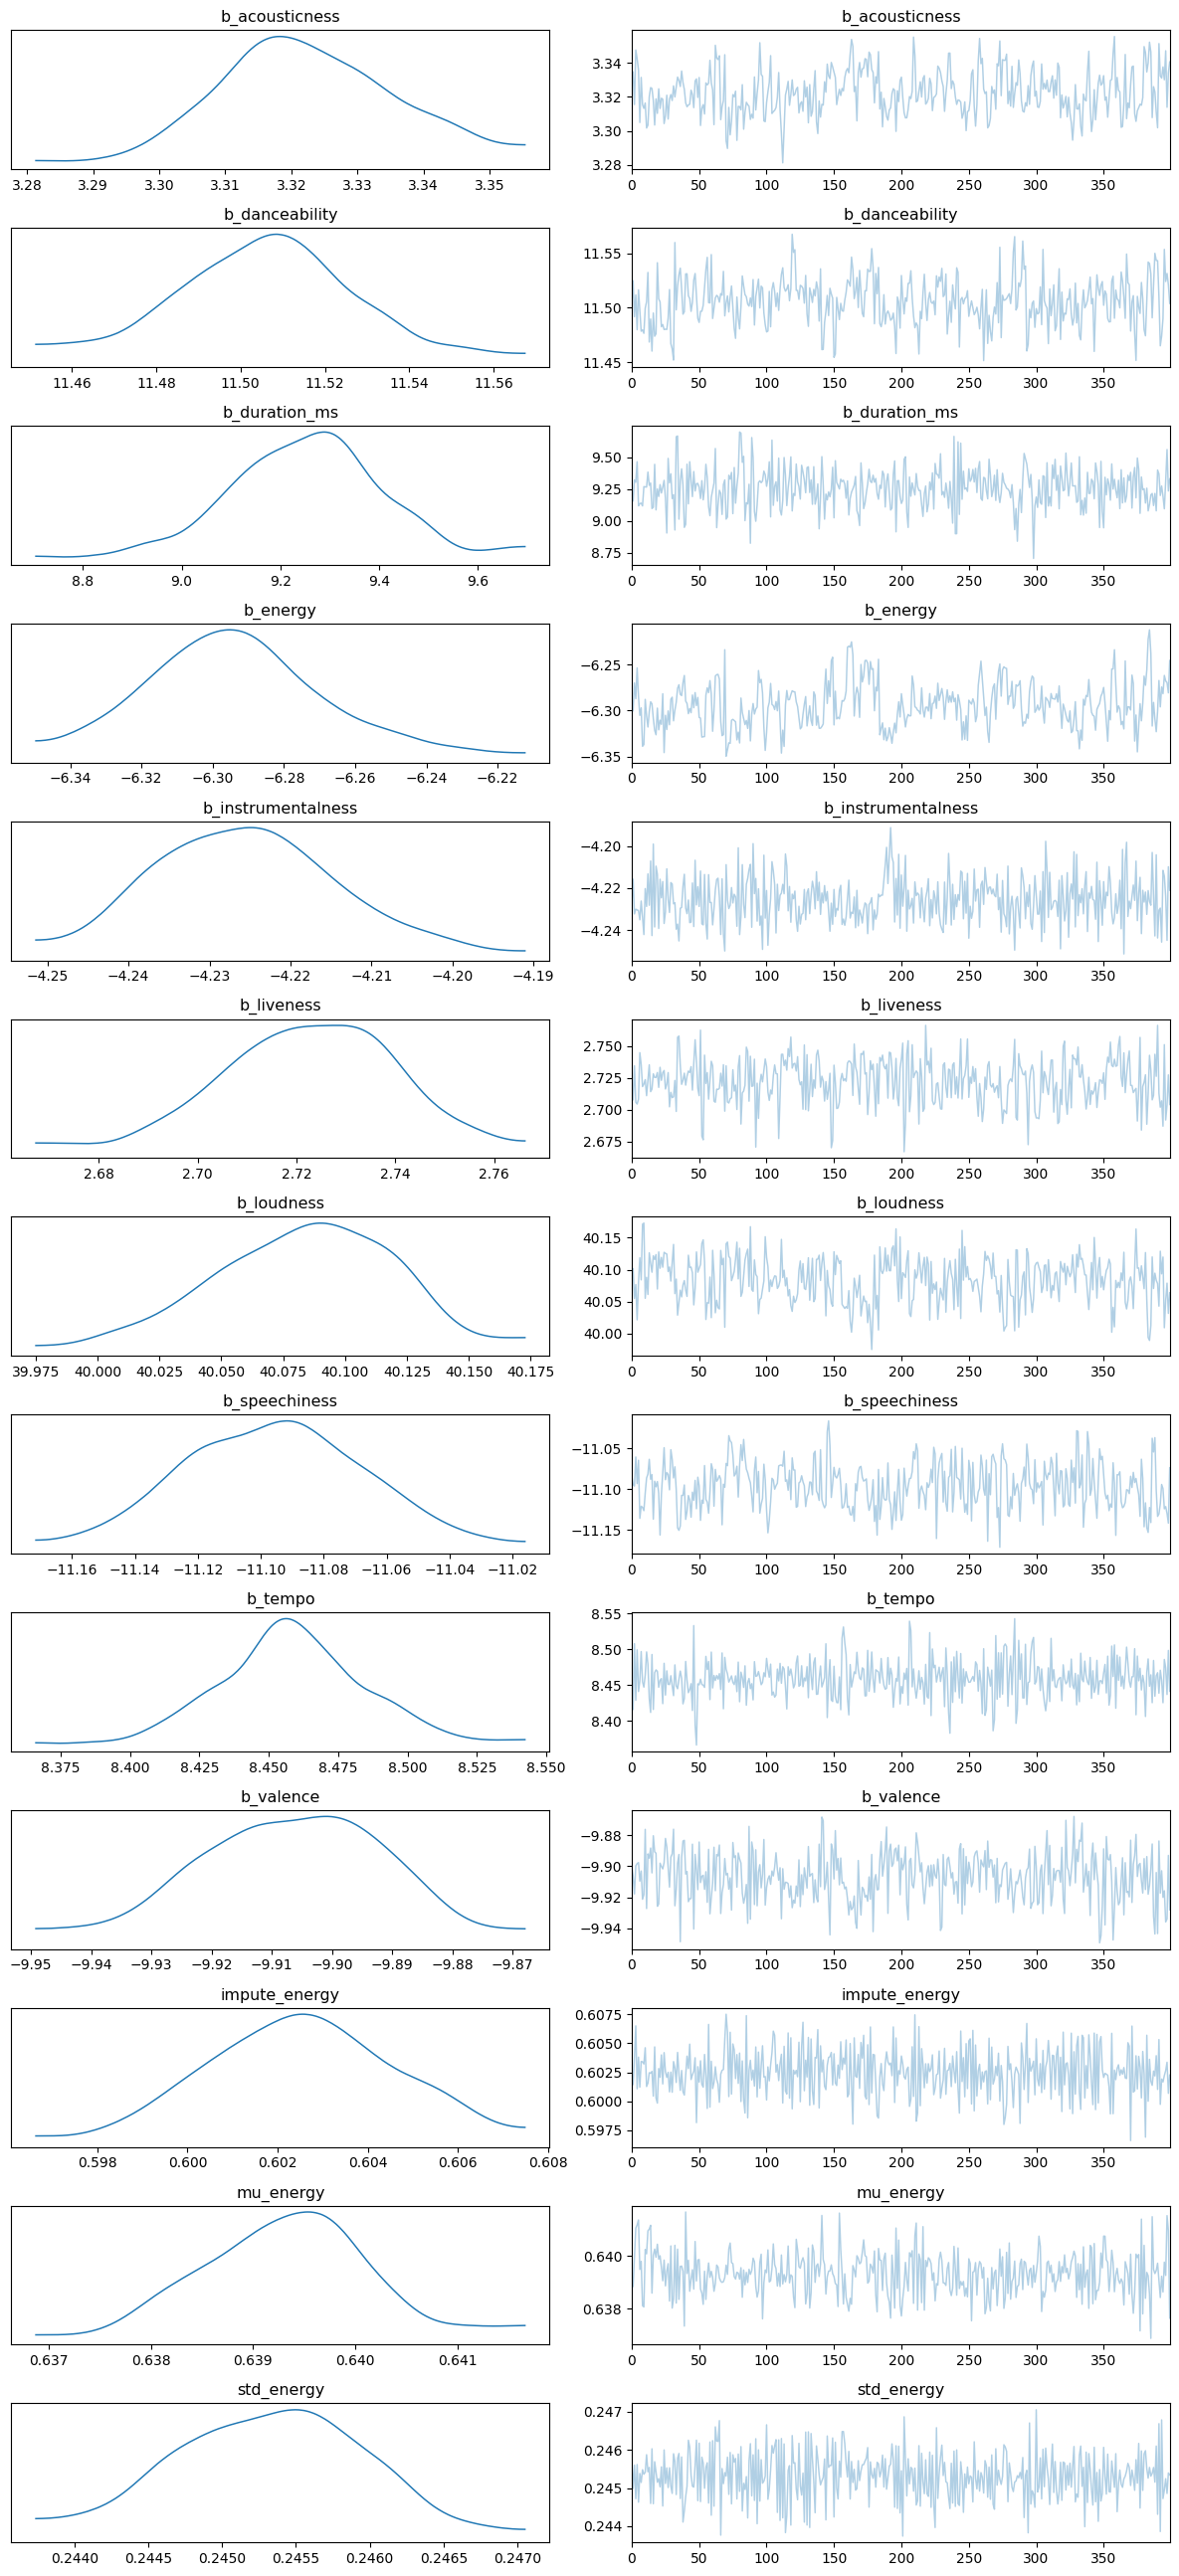

In [ ]:
az.plot_trace(pyro_data);
plt.tight_layout()

Ground True value:  32
Prediction Mean:  34.91653623663679


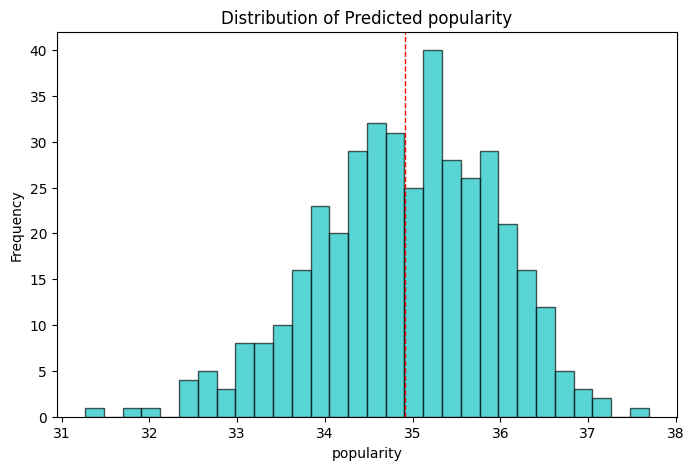

In [ ]:
def predict_and_plot_sample(model, samples, input_data):
    predictive = Predictive(model, samples, return_sites=["popularity"])

    posterior_predictive_one = predictive(input_data)

    predicted_prices = posterior_predictive_one["popularity"].detach().numpy().squeeze()

    print("Ground True value: ", input_data["popularity"].values.squeeze())

    prediction_mean = predicted_prices.mean()
    print("Prediction Mean: ", prediction_mean)

    plt.figure(figsize=(8, 5))
    plt.hist(predicted_prices, color='c', edgecolor='k', alpha=0.65, bins=30)
    plt.axvline(prediction_mean, color='r', linestyle='dashed', linewidth=1)
    plt.xlabel('popularity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted popularity')
    plt.show()

df_predict_one = df_predict.sample(n=1)
posterior_samples = mcmc.get_samples()

predict_and_plot_sample(model, posterior_samples, df_predict_one)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

posterior_predictive = Predictive(model, posterior_samples)
predicted_samples = posterior_predictive(df_predict)

predicted_values_test = predicted_samples["popularity"].detach().numpy().mean(axis=0)

true_values_test = df_predict["popularity"].values

mae_test = mean_absolute_error(true_values_test, predicted_values_test)
mse_test = mean_squared_error(true_values_test, predicted_values_test)
rmse_test = mean_squared_error(true_values_test, predicted_values_test, squared=False)
r2_test = r2_score(true_values_test, predicted_values_test)

print(f'Test Mean Absolute Error (MAE): {mae_test}')
print(f'Test Mean Squared Error (MSE): {mse_test}')
print(f'Test Root Mean Squared Error (RMSE): {rmse_test}')
print(f'Test R-squared (R2): {r2_test}')

Test Mean Absolute Error (MAE): 18.388508451758245
Test Mean Squared Error (MSE): 487.7069628262295
Test Root Mean Squared Error (RMSE): 22.084088453595488
Test R-squared (R2): 0.011700397353939462


In [ ]:
df_reg = df
df_reg.dropna(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

y  = df_reg['popularity']
X = df_reg.drop(['popularity'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

In [ ]:
mae_test = mean_absolute_error(y_test, y_pred)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
r2_test = r2_score(y_test, y_pred)


print(f'Test Mean Absolute Error (MAE): {mae_test}')
print(f'Test Mean Squared Error (MSE): {mse_test}')
print(f'Test Root Mean Squared Error (RMSE): {rmse_test}')
print(f'Test R-squared (R2): {r2_test}')

Test Mean Absolute Error (MAE): 18.33282467924675
Test Mean Squared Error (MSE): 484.083826717078
Test Root Mean Squared Error (RMSE): 22.001905070176946
Test R-squared (R2): 0.02473758550827032
